# Laboratory work №4

### Maslennikova Elizaveta, Shchegletova Tatyana 18IAD

#### loss = :top1, opt = :sgdm, agg = :sum, constr = :nneg

In [1]:
import pandas as pd
from sklearn import datasets
import sys
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import math
from scipy.sparse import csc_matrix, csr_matrix, linalg, diags
import numpy as np
from nltk.corpus import stopwords
import heapq
import json
from sklearn.feature_extraction.text import CountVectorizer
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import re 
import nltk  
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elizavetamaslennikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Reading data 

In [3]:
data = pd.read_json('output.json')
data.head()

,text,title
0,"Телеведущая Ксения Собчак считает, что художе...","Серебренников создал не просто театр, а ""центр..."
1,Интернет-сервис Amazo удалил с сайта объявлени...,"Американка сняла на видео ""профессиональный"" ф..."
2,"Волейболисты ""Урала"" достойно сыграли против к...","Антонов: волейболисты ""Урала"" рады, что ""Зенит..."
3,Спортивный арбитражный суд (CAS) оправдал росс...,Даже CAS не аргумент. Почему МОК нарушает олим...
4,Вашингтон пытается подвергнуть сомнению право...,США подвергают сомнению право России на самооб...


In [4]:
data.shape

(103778, 2)

In [5]:
data.describe()

,text,title
count,103778,103778
unique,103599,103284
top,Ria.ru предлагает вниманию читателей самые ярк...,В Минобороны отчитались о ситуации в зонах деэ...
freq,14,111


#### Delete duplicates from titles and texts:

In [6]:
data = data.drop_duplicates()
data = data.drop_duplicates(subset=["text"])
data = data.drop_duplicates(subset=["title"])
data.describe()

,text,title
count,103132,103132
unique,103132,103132
top,". Госсекретарь США Майк Помпео не исключает, ч...","СМИ: Пол Джордж договорился с ""Оклахома-Сити"" ..."
freq,1,1


In [7]:
data.index = range(0, data.shape[0])
data.tail()

,text,title
103127,Монах-францисканец Питер Табичи на церемонии ...,"В Дубае ""лучшему учителю в мире"" вручили милли..."
103128,Выводы Минюста США по итогам расследования сп...,В Белом доме прокомментировали выводы Минюста ...
103129,Российский гроссмейстер Владислав Артемьев по...,Артемьев победил в шестом туре чемпионата Евро...
103130,"Президент США Дональд Трамп заявил, что вывод...",Трамп прокомментировал выводы Минюста по рассл...
103131,Бомбардировки Сербии силами НАТО были преступ...,Вучич назвал бомбардировки Сербии силами НАТО ...


In [8]:
title_texts = pd.concat([data['title'], data["text"]], ignore_index=True)
title_texts.shape

(206264,)

#### Create vocabulary and transform input data 

In [9]:
model = Mystem()

def tokenize(string):
    string = re.sub(r'\W', ' ',  string)
    string = re.sub(r'\s+', ' ', string, flags=re.I)
    tokens = re.findall(r'\b[0-9А-Яа-я]{1,}\b', string)
    tokens = ' '.join(tokens)
    lemmas = model.lemmatize(tokens)
    words = [l for l in lemmas if len(l) > 1]
    return words

In [10]:
vectorizer = CountVectorizer(
    tokenizer = tokenize,
    min_df = 10, 
    max_df = 0.3,
    stop_words=stopwords.words('russian'))

vectorizer.fit(title_texts)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.3, max_features=None, min_df=10,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', '...гда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x1473a78c8>, vocabulary=None)

In [11]:
vocabulary = vectorizer.vocabulary_

In [12]:
list(vocabulary.items())[:10]

[('серебренников', 12165),
 ('создавать', 12612),
 ('просто', 10770),
 ('театр', 13383),
 ('центр', 14891),
 ('сила', 12223),
 ('считать', 13233),
 ('собчак', 12553),
 ('американка', 628),
 ('снимать', 12519)]

In [13]:
ind_to_word = {}
for w, i in vocabulary.items():
    ind_to_word[i] = w
list(ind_to_word.items())[:10]

[(12165, 'серебренников'),
 (12612, 'создавать'),
 (10770, 'просто'),
 (13383, 'театр'),
 (14891, 'центр'),
 (12223, 'сила'),
 (13233, 'считать'),
 (12553, 'собчак'),
 (628, 'американка'),
 (12519, 'снимать')]

In [14]:
tokinizer = vectorizer.build_tokenizer()

In [15]:
title_tok = vectorizer.transform(data['title'])
title_tok

<103132x15759 sparse matrix of type '<class 'numpy.int64'>'
	with 712001 stored elements in Compressed Sparse Row format>

In [16]:
text_tok = vectorizer.transform(data['text'])
text_tok

<103132x15759 sparse matrix of type '<class 'numpy.int64'>'
	with 2016978 stored elements in Compressed Sparse Row format>

In [17]:
n_tokens = text_tok.shape[1]

In [18]:
data_list = []
n_1 = data.shape[0]
for i in range(0, n_1):
    title = title_tok.getrow(i)
    title_ind = []
    for ind, n in zip(title.indices, title.data):
        title_ind += [ind for _ in range(0, n)]
    text = text_tok.getrow(i)
    text_ind = []
    for ind, n in zip(text.indices, text.data):
        text_ind += [ind for _ in range(0, n)]
    data_list.append([title_ind, text_ind])
        
data_tokens = pd.DataFrame(data_list, columns=["Title", "Text"])
data_tokens.head()

,Title,Text
0,"[10770, 12165, 12223, 12553, 12612, 13233, 133...","[2844, 5905, 6068, 8910, 10770, 10970, 10977, ..."
1,"[628, 1940, 9510, 10816, 12519]","[1940, 4878, 5905, 8444, 8477, 8695, 10634, 10..."
2,"[753, 2188, 4529, 5274, 10997, 14119]","[753, 2188, 2363, 3779, 4485, 4529, 5087, 6826..."
3,"[794, 7238, 7672, 8599, 10179, 14667]","[790, 2231, 3590, 3702, 3744, 4646, 5645, 6915..."
4,"[4485, 7032, 9665, 10209, 11635, 11862, 12659,...","[1742, 2542, 2839, 3003, 3382, 3681, 4896, 564..."


In [19]:
data_tokens.shape

(103132, 2)

#### Create embedding

In [175]:
embending_size = 256

In [176]:
mu, sigma = 0.0001, 0.00001
d = np.random.normal(mu, sigma, embending_size*n_tokens)

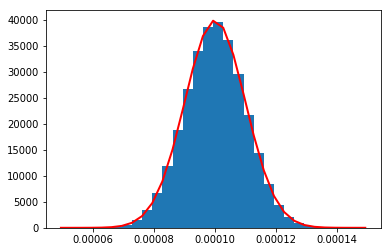

In [216]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(d, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()

w_T - transpose embedding matrix, initialize randomly with normal distribution

In [217]:
w_T = np.array(d)
w_T

array([1.17781357e-04, 1.06017536e-04, 8.89504586e-05, ...,
       1.11240294e-04, 9.17206973e-05, 1.15243317e-04])

In [218]:
w_T = np.reshape(w_T, newshape=(n_tokens, embending_size))
w_T.shape

(15759, 256)

vt - vector with "upgrade vectors" from last step

In [219]:
vt = {}
vt["True_title"] = [0 for _ in range(0, embending_size)]
vt["True_text"] = [0 for _ in range(0, embending_size)]
vt["False_text"] = [0 for _ in range(0, embending_size)]

In [220]:
train_data, test_data = train_test_split(data_tokens, test_size=3132, random_state=42)
print(train_data.shape)
print(test_data.shape)

(100000, 2)
(3132, 2)


#### Training embedding

In [221]:
def aggr(w_T, text):
    text_w = np.zeros((w_T.shape[1]))
    for t in text:
        text_w += w_T[t]
    return text_w

In [222]:
def scalar_mul(vect_1, vect_2):
    if vect_1.shape != vect_2.shape:
        print("Shapes of vectors are not equal")
        return -1
    norm_1 = np.math.sqrt(np.sum([a*a for a in vect_1]))
    norm_2 = np.math.sqrt(np.sum([a*a for a in vect_2]))
    dist = np.sum([vect_1[i]*vect_2[i] for i in range(0, len(vect_1))])
    dist = dist / (norm_1*norm_2)
    return dist

In [223]:
def top1(f1, f2):
    d = f1 - f2
    return 1/(1 + np.exp(-d))

In [224]:
def loss(u, v1, v2):
    f1 = scalar_mul(u, v1)
    f2 = scalar_mul(u, v2)
    loss_val = top1(f1, f2)
    return loss_val

In [225]:
def update_row(w_T, vt, text):
    for t in text:
        for i in range(0, len(vt)):
            w_T[t][i] = w_T[t][i] - vt[i]
    return w_T

In [226]:
def check_matrix(w_T):
    n_1 = w_T.shape[0]
    n_2 = w_T.shape[1]
    for i in range(0, n_1):
        for j in range(0, n_2):
            if w_T[i][j] < 0:
                w_T[i][j] = 0.000000001
            elif w_T[i][j] == np.inf:
                w_T[i][j] = 10000000
    return w_T

In [227]:
# train embedding
def train(train_data, w_T, vt, batch_size=1000, gamma=0.01, n=0.001):
    indexes = train_data.index.tolist()
    np.random.shuffle(indexes)
    for i in range(0, batch_size):
        # choice texts
        true_ind = indexes[i]
        false_ind = np.random.choice(indexes)
        while false_ind == true_ind:
            false_ind = np.random.choice(indexes)
            
        true_text = train_data["Text"][true_ind]
        true_title = train_data["Title"][true_ind]
        false_text = train_data["Text"][false_ind]
        
        # aggrigation
        true_text_w = aggr(w_T, true_text)
        true_title_w = aggr(w_T, true_title)
        false_text_w = aggr(w_T, false_text)
        
        # evaluate loss function
        loss_val = loss(true_title_w, true_text_w, false_text_w)
        
        if loss_val > 0.01:
        
            # update weights
            g_1 = false_text_w - true_text_w
            vt["True_title"] = np.multiply(gamma, vt["True_title"]) + n*g_1
            w_T = update_row(w_T, vt["True_title"], true_title)

            vt["True_text"] = np.multiply(gamma, vt["True_text"]) - n*true_title_w
            w_T = update_row(w_T, vt["True_text"], true_text)

            vt["False_text"] = np.multiply(gamma, vt["False_text"]) + n*true_title_w
            w_T = update_row(w_T, vt["False_text"], false_text)
            
        if i%100 == 0:
            # check values in matrix
            w_T = check_matrix(w_T)
        
        
        sys.stdout.write("\r%f%%" % (100*(i+1)/batch_size))
        sys.stdout.flush()

In [228]:
# calculate frecuency
def evaluate(test_data, w_T, batch_size=1000, k=5):
    count = 0
    test_indexes = test_data.index.tolist()
    np.random.shuffle(test_indexes)
    for i in range(0, batch_size):
        ind_1 = test_indexes[i]
        loss_arr = []
        for j in range(0, len(test_indexes)):
            ind_2 = test_indexes[j]
            q1 = aggr(w_T, test_data["Title"][ind_1])
            q2 = aggr(w_T, test_data["Text"][ind_2])
            s = 1 - cosine_similarity(q1, q2)
            loss_arr.append(s[0][0])
        sort_loss_arr = np.sort(loss_arr)
        treshold = sort_loss_arr[k-1]
        if loss_arr[i] < treshold:
            count += 1
        sys.stdout.write("\r\t%f%%" % (100*(i+1)/batch_size))
        sys.stdout.flush()
    return count / batch_size

In [229]:
def train_model(train_data, test_data, w_T, vt, n_epoch=1):
    for ep in range(0, n_epoch):
        print("\nEpoch #" + str(ep))
        train(train_data, w_T, vt)
        print("\n\tEvaluate frecuency:")
        frecuency = evaluate(test_data, w_T)
        print("\n\tFrecuency is", frecuency)

#### Training model 

In [230]:
train_model(train_data, test_data, w_T, vt, n_epoch=5)


Epoch #0
100.000000%
	Evaluate frecuency:
	100.000000%
	Frecuency is 0.748

Epoch #1
100.000000%
	Evaluate frecuency:
	100.000000%
	Frecuency is 0.792

Epoch #2
100.000000%
	Evaluate frecuency:
	100.000000%
	Frecuency is 0.837

Epoch #3
100.000000%
	Evaluate frecuency:
	100.000000%
	Frecuency is 0.843

Epoch #4
100.000000%
	Evaluate frecuency:
	100.000000%
	Frecuency is 0.847


In [63]:
# find neighboring words
def knn(w_T, ind, k=10):
    l = []
    for i in range(0, w_T.shape[0]):
        l.append((i, 1 - cosine_similarity(w_T[ind], w_T[i])))
    dist_arr = np.array(l, dtype=[('index', int), ('dist', float)])
    dist_arr = np.sort(dist_arr, order='dist') 
    print("Input world -", ind_to_word[ind])
    print("Neighbors:")
    for j in range(0, k):
        if dist_arr[j]['index'] != ind:
            print("\t" + ind_to_word[dist_arr[j]['index']])

In [64]:
knn(w_T, 10924)

Input world - путин
Neighbors:
	встреча
	мид
	рф
	представитель
	владимир
	секретарь
	спартак
	база
	китайский
